In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import talib
import warnings
from sklearn.linear_model import LinearRegression
from sklearn import metrics
warnings.filterwarnings('ignore')

In [35]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import pandas as pd
pd.set_option('display.max_rows', 50000)
pd.set_option('display.max_columns', 50000)
pd.set_option('display.width', 100000)

In [36]:
df = pd.read_csv(r"C:\Users\ayush\Desktop\IITB\ZeltaLabPS\BackTesting\data\data\btcusdt_1h_train.csv")
df2 = pd.read_csv(r"C:\Users\ayush\Desktop\IITB\ZeltaLabPS\BackTesting\dataset\test\btcusdt_1h_test.csv")
df3 = pd.read_csv(r"C:\Users\ayush\Desktop\IITB\ZeltaLabPS\BackTesting\src\Ayush\data.csv")


In [37]:
dfk = df3.copy()
dfk.rename(columns={'date': 'datetime'}, inplace=True)
dfk = dfk[['open', 'high', 'low', 'close', 'datetime']]
df2k = df2[['open', 'high', 'low', 'close', 'datetime']]

dfk['datetime'] = pd.to_datetime(dfk['datetime'], format='%Y-%m-%d %H:%M:%S')
df2k['datetime'] = pd.to_datetime(df2['datetime'], format='%Y-%m-%d %H:%M:%S')

df_merged = pd.concat([df2k[['datetime', 'open', 'high', 'low', 'close']], dfk[['datetime', 'open', 'high', 'low', 'close']]])


In [38]:
df_merged = df_merged.dropna()
df_merged = df_merged.reset_index(drop=True)

In [39]:
df_merged.shape

(20284, 5)

In [40]:
df_combined = pd.concat([df2[['datetime', 'open', 'high', 'low', 'close']], df3[['date', 'open', 'high', 'low', 'close']]])
# df_combined = df_combined.reset_index(drop=True)
# df_combined = df_combined.dropna()
df_combined.head()
df_combined.tail()
# df_combined.shape

,datetime,open,high,low,close,date
14879,NaN,41248.0,41248.0,41069.0,41212.0,2023-12-12 20:00:00
14880,NaN,41227.0,41327.0,41038.0,41094.0,2023-12-12 21:00:00
14881,NaN,41110.0,41249.0,41097.0,41247.0,2023-12-12 22:00:00
14882,NaN,41256.0,41532.0,41256.0,41498.0,2023-12-12 23:00:00
14883,NaN,41491.0,41491.0,41406.0,41427.0,2023-12-13 0:00:00


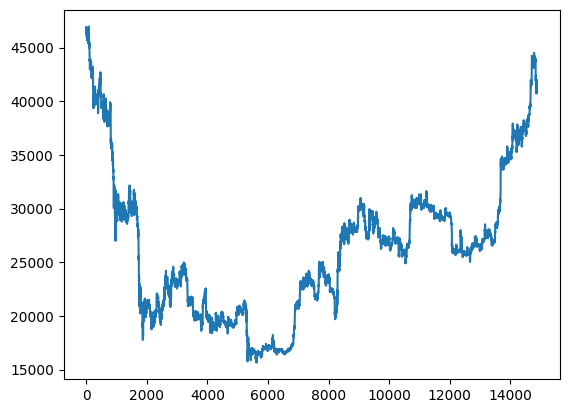

In [41]:
plt.plot(df3['close'])

In [42]:
def stochastic_fast(df, k_period=14, d_period=3):
    """
    Calculate Stochastic Fast K and D values.

    Parameters:
    - df: DataFrame with 'High', 'Low', and 'Close' columns.
    - k_period: The period for %K calculation.
    - d_period: The period for %D calculation.

    Returns:
    - DataFrame with 'StochF_K' and 'StochF_D' columns.
    """

    # Calculate %K
    df['Lowest_Low'] = df['low'].rolling(window=k_period).min()
    df['Highest_High'] = df['high'].rolling(window=k_period).max()
    df['StochF_K'] = 100 * ((df['close'] - df['Lowest_Low']) / (df['Highest_High'] - df['Lowest_Low']))

    # Calculate %D
    df['StochF_D'] = df['StochF_K'].rolling(window=d_period).mean()

    # Drop temporary columns
    df.drop(['Lowest_Low', 'Highest_High'], axis=1, inplace=True)

    return df

# Example usage:
# Assuming you have a DataFrame 'df' with columns 'High', 'Low', and 'Close'
df = stochastic_fast(df)


In [43]:
def print_buckets(df, alphas, rets = ['ret_10', 'ret_30', 'ret_60', 'ret_300', 'tick_10'], aggfunc = ['mean', 'median', 'count'], buckets = 10):
# def print_buckets(df, alphas, rets = ['ret_10', 'ret_30', 'iv_10'], aggfunc = ['mean', 'median', 'count']):
# def print_buckets(df, alphas, rets = ['tick_10', 'tick_30', 'tick_60', 'tick_300'], aggfunc = ['mean', 'median', 'count']):
# def print_buckets(df, alphas, rets = ['ret_60', 'ret_300', 'iv_60'], aggfunc = ['mean', 'median', 'count']):
    for alpha in alphas:
        msg = df.pivot_table(index = pd.qcut(df[alpha],buckets,duplicates='drop'), values=rets, aggfunc=aggfunc)
        print(msg)

def print_corrs(df, alphas, rets = ['ret_10', 'ret_30', 'ret_60', 'ret_300']):
# def print_corrs(df, alphas, rets = ['ret_10', 'ret_30', 'iv_10']):
# def print_corrs(df, alphas, rets = ['tick_10', 'tick_30', 'tick_60', 'tick_300']):
# def print_corrs(df, alphas, rets = ['ret_60', 'ret_300', 'iv_60']):
    msg = "                                      "
    for ret in rets:
        msg += f"{ret:>8s}"
    print(msg)
    for alpha in alphas:
        msg = f"{alpha:30s} corr -> "
        for ret in rets:
            msg += f"{df[alpha].corr(df[ret])*100:7.2f} "
        print(msg)
    print()

In [44]:
def ret(df):
    df['change_5'] = df['close'].rolling(window=5).mean().pct_change() * 1e4

    df['ret_5'] = df['close'].shift(-5)
    df['ret_1'] = df['close'].shift(-1)
    df['ret_10'] = df['close'].shift(-10)
    df['ret_30'] = df['close'].shift(-30)

    df['ret_5'] = (df['ret_5'] - df['close']) / df['close'] * 1e4
    df['ret_1'] = (df['ret_1'] - df['close']) / df['close'] * 1e4
    df['ret_10'] = (df['ret_10'] - df['close']) / df['close'] * 1e4
    df['ret_30'] = (df['ret_30'] - df['close']) / df['close'] * 1e4

    df.head(10)
    df = df.dropna()
    df = df.reset_index(drop=True)
    return df

df = ret(df)
df2 = ret(df2)
df3 = ret(df3)
df_merged = ret(df_merged)

In [45]:
print(df3[['close', 'ret_1']].head(10))

      close      ret_1
0  46406.83   0.000000
1  46406.83  34.663001
2  46567.69  -2.117348
3  46557.83  11.961468
4  46613.52   0.000000
5  46613.52   0.000000
6  46613.52   0.000000
7  46613.52  -5.105815
8  46589.72  11.976891
9  46645.52  34.481339


In [46]:
print_corrs(df, ['StochF_K', 'StochF_D'], ['ret_5', 'ret_1', 'ret_10', 'ret_30'])
print_buckets(df, ['StochF_K', 'StochF_D'], ['ret_5', 'ret_1', 'ret_10', 'ret_30'])

                                         ret_5   ret_1  ret_10  ret_30
StochF_K                       corr ->    0.77   -1.34    3.27   -0.03 
StochF_D                       corr ->    1.96   -0.26    4.62    0.44 

                      mean                                     median                                  count                    
                     ret_1     ret_10     ret_30     ret_5      ret_1     ret_10     ret_30      ret_5 ret_1 ret_10 ret_30 ret_5
StochF_K                                                                                                                        
(-0.001, 18.191]  6.453929  -5.747664  18.697713  2.923199  12.422021   8.038901  38.819398  16.273526  2232   2232   2232  2232
(18.191, 27.094] -2.632393 -24.282961  -7.923011 -8.604649   3.662598   6.720811  24.540521   9.145676  2231   2231   2231  2231
(27.094, 36.089]  0.141137  -3.726877   5.607595 -4.993966   2.712988   5.880569  18.049781   4.663959  2231   2231   2231  2231
(36.089, 4

In [47]:
def datafunc(df):
    try:
        df['volume'] = 0
    except:
        pass
    df['AD'] = talib.AD(df['high'], df['low'], df['close'], df['volume'])
    df['APO'] = talib.APO(df['close'], fastperiod=12, slowperiod=26)
    df['AROON_UP'], df['AROON_DOWN'] = talib.AROON(df['high'], df['low'], timeperiod=14)
    df['MOM'] = talib.MOM(df['close'], timeperiod=10)
    df['PLUS_DI'] = talib.PLUS_DI(df['high'], df['low'], df['close'], timeperiod=14)
    df['PLUS_DM'] = talib.PLUS_DM(df['high'], df['low'], timeperiod=14)
    df['ROC'] = talib.ROC(df['close'], timeperiod=10)
    df['ROCP'] = talib.ROCP(df['close'], timeperiod=10)
    df['ROCR'] = talib.ROCR(df['close'], timeperiod=10)
    df['ROCR100'] = talib.ROCR100(df['close'], timeperiod=10)
    df['STOCH_K'], df['STOCH_D'] = talib.STOCH(df['high'], df['low'], df['close'], fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
    df['STOCHF_K'], df['STOCHF_D'] = talib.STOCHF(df['high'], df['low'], df['close'], fastk_period=5, fastd_period=3, fastd_matype=0)
    df['STOCHRSI_K'], df['STOCHRSI_D'] = talib.STOCHRSI(df['close'], timeperiod=14, fastk_period=5, fastd_period=3, fastd_matype=0)
    df['ULTOSC'] = talib.ULTOSC(df['high'], df['low'], df['close'], timeperiod1=7, timeperiod2=14, timeperiod3=28)
    df['WILLR'] = talib.WILLR(df['high'], df['low'], df['close'], timeperiod=14)

    df['ADOSC'] = talib.ADOSC(df['high'], df['low'], df['close'], df['volume'], fastperiod=3, slowperiod=10)
    df['BOP'] = talib.BOP(df['open'], df['high'], df['low'], df['close'])
    df['CMO'] = talib.CMO(df['close'], timeperiod=14)
    df['DX'] = talib.DX(df['high'], df['low'], df['close'], timeperiod=14)
    df['HT_DCPERIOD'] = talib.HT_DCPERIOD(df['close'])
    df['HT_DCPHASE'] = talib.HT_DCPHASE(df['close'])
    df['HT_PHASOR_INPHASE'], df['HT_PHASOR_QUADRATURE'] = talib.HT_PHASOR(df['close'])
    df['HT_SINE'], df['HT_LEADSINE'] = talib.HT_SINE(df['close'])
    df['HT_TRENDMODE'] = talib.HT_TRENDMODE(df['close'])
    df['LINEARREG'] = talib.LINEARREG(df['close'], timeperiod=14)
    df['LINEARREG_ANGLE'] = talib.LINEARREG_ANGLE(df['close'], timeperiod=14)
    df['LINEARREG_INTERCEPT'] = talib.LINEARREG_INTERCEPT(df['close'], timeperiod=14)
    df['LINEARREG_SLOPE'] = talib.LINEARREG_SLOPE(df['close'], timeperiod=14)
    df['MAX'] = talib.MAX(df['close'], timeperiod=14)
    df['MAXINDEX'] = talib.MAXINDEX(df['close'], timeperiod=14)
    df['MEDPRICE'] = talib.MEDPRICE(df['high'], df['low'])
    df['SAREXT'] = talib.SAREXT(df['high'], df['low'], startvalue=0, offsetonreverse=0, accelerationinitlong=0, accelerationlong=0, accelerationmaxlong=0, accelerationinitshort=0, accelerationshort=0, accelerationmaxshort=0)

    df['ATR'] = talib.ATR(df['high'], df['low'], df['close'], timeperiod=14)
    df['NATR'] = talib.NATR(df['high'], df['low'], df['close'], timeperiod=14)
    df['TRANGE'] = talib.TRANGE(df['high'], df['low'], df['close'])
    df['ADX'] = talib.ADX(df['high'], df['low'], df['close'], timeperiod=14)
    df['ADXR'] = talib.ADXR(df['high'], df['low'], df['close'], timeperiod=14)
    df['CCI'] = talib.CCI(df['high'], df['low'], df['close'], timeperiod=14)
    df['CMO'] = talib.CMO(df['close'], timeperiod=14)
    df['DX'] = talib.DX(df['high'], df['low'], df['close'], timeperiod=14)
    df['HT_TRENDLINE'] = talib.HT_TRENDLINE(df['close'])
    df['HT_DCPHASE'] = talib.HT_DCPHASE(df['close'])
    df['LINEARREG_ANGLE'] = talib.LINEARREG_ANGLE(df['close'], timeperiod=14)
    df['LINEARREG_INTERCEPT'] = talib.LINEARREG_INTERCEPT(df['close'], timeperiod=14)
    df['LINEARREG_SLOPE'] = talib.LINEARREG_SLOPE(df['close'], timeperiod=14)
    df['STDDEV'] = talib.STDDEV(df['close'], timeperiod=5, nbdev=1)
    df['TSF'] = talib.TSF(df['close'], timeperiod=14) - df['close']
    df['VAR'] = talib.VAR(df['close'], timeperiod=5, nbdev=1)
     
    
    return df

In [48]:
print(df3.head())

# df3 = df3.iloc[1:]

# df3.columns = ['serial','timestamp', 'symbol','open', 'high', 'low', 'close', 'volume', 'vol_usd']

         unix                date    symbol      open      high       low     close  Volume BTC  Volume USDT   change_5      ret_5      ret_1     ret_10     ret_30
0  1648864800  2022-04-02 2:00:00  BTC/USDT  46435.46  46435.46  46406.83  46406.83    0.041542  1927.838101   3.761998  44.538703   0.000000  86.092931   9.524460
1  1648868400  2022-04-02 3:00:00  BTC/USDT  46406.83  46406.83  46406.83  46406.83    0.000000     0.000000   5.222722  44.538703  34.663001  86.092931   9.524460
2  1648872000  2022-04-02 4:00:00  BTC/USDT  46618.10  46632.22  46567.69  46567.69    0.114339  5324.506367  10.751671   9.841588  -2.117348  51.252274 -53.318084
3  1648875600  2022-04-02 5:00:00  BTC/USDT  46545.18  46557.83  46504.57  46557.83    0.036186  1684.734187 -13.795252   6.849546  11.961468 -70.209458 -66.850195
4  1648879200  2022-04-02 6:00:00  BTC/USDT  46613.52  46613.53  46613.52  46613.52    0.069000  3216.332880 -13.196342   6.864961   0.000000 -82.072755 -78.786155


In [49]:
# plt.plot(df3['close'], df3['date'])

In [50]:
df = datafunc(df)
df2 = datafunc(df2)
df3 = datafunc(df3)
df_merged = datafunc(df_merged)

In [51]:
alphas = ['APO', 'AROON_UP', 'AROON_DOWN', 'MOM', 'PLUS_DI', 'PLUS_DM', 'ROC', 'ROCP', 'ROCR', 'ROCR100', 'STOCH_K', 'STOCH_D', 'STOCHF_K', 'STOCHF_D', 'STOCHRSI_K', 'STOCHRSI_D', 'ULTOSC', 'WILLR', 'ADOSC', 'BOP', 'CMO', 'DX', 'HT_DCPERIOD', 'HT_DCPHASE', 'HT_PHASOR_INPHASE', 'HT_PHASOR_QUADRATURE', 'HT_SINE', 'HT_LEADSINE', 'HT_TRENDMODE', 'LINEARREG', 'LINEARREG_ANGLE', 'LINEARREG_INTERCEPT', 'LINEARREG_SLOPE', 'MAX', 'MAXINDEX', 'MEDPRICE', 'SAREXT', 'ATR', 'NATR', 'TRANGE', 'ADX', 'ADXR', 'CCI', 'CMO', 'DX', 'HT_TRENDLINE', 'HT_DCPHASE', 'LINEARREG_ANGLE', 'LINEARREG_INTERCEPT', 'LINEARREG_SLOPE', 'STDDEV', 'TSF', 'VAR']

In [52]:
# alphas = ['AD', 'APO', 'AROON_UP', 'AROON_DOWN', 'MOM', 'PLUS_DI', 'PLUS_DM', 'ROC', 'ROCP', 'ROCR', 'ROCR100', 'STOCH_K', 'STOCH_D', 'STOCHF_K', 'STOCHF_D', 'STOCHRSI_K', 'STOCHRSI_D', 'ULTOSC', 'WILLR', '']

In [53]:
print_corrs(df, alphas, ['ret_5', 'ret_1', 'ret_10', 'ret_30'])

                                         ret_5   ret_1  ret_10  ret_30
APO                            corr ->    5.22    2.06    4.44   -1.88 
AROON_UP                       corr ->    0.01    1.51   -3.56   -1.02 
AROON_DOWN                     corr ->    3.26   -0.23    6.52    1.70 
MOM                            corr ->   -1.37   -3.01    3.62   -1.11 
PLUS_DI                        corr ->    3.55    1.12    5.50    2.19 
PLUS_DM                        corr ->    0.39   -0.29    1.14   -1.13 
ROC                            corr ->   -1.53   -2.85    3.78   -1.65 
ROCP                           corr ->   -1.53   -2.85    3.78   -1.65 
ROCR                           corr ->   -1.53   -2.85    3.78   -1.65 
ROCR100                        corr ->   -1.53   -2.85    3.78   -1.65 
STOCH_K                        corr ->   -1.24   -1.28   -0.17    0.15 
STOCH_D                        corr ->   -1.09   -0.55    1.06    0.48 
STOCHF_K                       corr ->   -1.71   -2.40   -1.11   

In [54]:
print_buckets(df, ['TSF'], ['ret_5', 'ret_1', 'ret_10', 'ret_30'])

                         mean                                      median                                  count                    
                        ret_1     ret_10     ret_30      ret_5      ret_1     ret_10     ret_30      ret_5 ret_1 ret_10 ret_30 ret_5
TSF                                                                                                                                 
(-958.667, -77.188] -6.587493 -42.391414 -27.704207 -20.458517  -9.819428 -16.041781  -4.044027 -14.461958  2230   2230   2230  2230
(-77.188, -38.468]   1.617666 -10.964054  -9.468355  -5.889505  -3.600948  -8.172244  -5.702095  -3.999375  2230   2230   2230  2230
(-38.468, -19.283]   1.797356  -0.130790   4.001387   5.047423  -1.641678  -0.002956   9.931201   2.536447  2230   2230   2230  2230
(-19.283, -8.086]    4.456516  11.721010  18.697587  12.890091   0.464599   1.203649   2.295603   3.753552  2229   2229   2229  2229
(-8.086, 0.19]      -1.099201   4.589263  22.925003   3.195781  -0.31

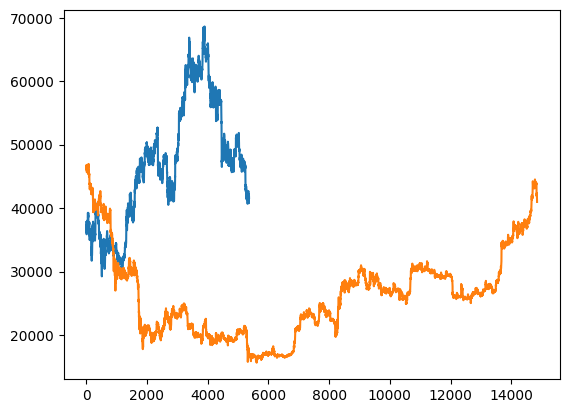

In [55]:
plt.plot(df2['close'])
plt.plot(df3['close'])

In [56]:
print_corrs(df_merged, alphas, ['ret_5', 'ret_1', 'ret_10', 'ret_30'])

                                         ret_5   ret_1  ret_10  ret_30
APO                            corr ->    0.80    0.41    0.23   -0.24 
AROON_UP                       corr ->   -1.19    0.08   -2.46   -0.94 
AROON_DOWN                     corr ->   -0.99   -0.51   -0.59   -0.17 
MOM                            corr ->    0.15   -0.79    1.30    0.00 
PLUS_DI                        corr ->   -0.48   -0.27   -0.34   -1.70 
PLUS_DM                        corr ->    0.40    0.18    1.01    0.21 
ROC                            corr ->   -0.06   -1.37    1.42    0.52 
ROCP                           corr ->   -0.06   -1.37    1.42    0.52 
ROCR                           corr ->   -0.06   -1.37    1.42    0.52 
ROCR100                        corr ->   -0.06   -1.37    1.42    0.52 
STOCH_K                        corr ->   -1.31   -1.47   -0.06    0.08 
STOCH_D                        corr ->   -0.42   -1.03    0.65    0.28 
STOCHF_K                       corr ->   -1.76   -1.38   -0.71   

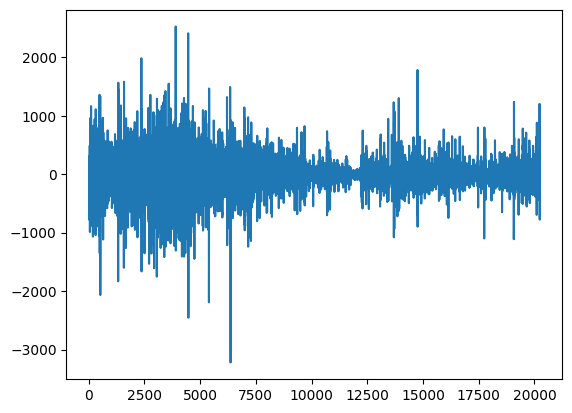

In [57]:
plt.plot(df_merged['TSF'])

In [58]:
print_buckets(df, ['SAREXT'], ['ret_5', 'ret_1', 'ret_10', 'ret_30'], buckets=100)
df['SAREXT'].describe()

                           mean                                  median                                count                     
                          ret_1    ret_10    ret_30     ret_5     ret_1    ret_10    ret_30     ret_5  ret_1 ret_10 ret_30  ret_5
SAREXT                                                                                                                           
(-17176.241, 12940.0]  0.259006  1.892909  5.892394  1.028617  0.831654  3.217058  5.946891  2.806905  22310  22310  22310  22310


count    22310.000000
mean    -16967.998909
std       2482.845283
min     -17176.240000
25%     -17176.240000
50%     -17176.240000
75%     -17176.240000
max      12940.000000
Name: SAREXT, dtype: float64

In [59]:
print_buckets(df, ['CMO'], ['ret_5', 'ret_1', 'ret_10', 'ret_30'])

                                   mean                                     median                                  count                    
                                  ret_1     ret_10     ret_30      ret_5     ret_1     ret_10     ret_30      ret_5 ret_1 ret_10 ret_30 ret_5
CMO                                                                                                                                          
(-91.27000000000001, -31.385]  0.389975 -27.180577 -13.656162  -9.970049  4.270474   2.233864  21.723455   4.389332  2230   2230   2230  2230
(-31.385, -19.076]             1.113078  -2.482911  23.029826  -4.715748  4.894177  16.410296  49.173579  11.830228  2230   2230   2230  2230
(-19.076, -11.3]               0.146128  12.075775  16.701956   6.803592  3.019340  13.569404  18.429225   9.900854  2229   2229   2229  2229
(-11.3, -4.969]               -1.871840  -1.026389 -12.187735   1.447264  1.412357  10.121750   4.971476   7.524777  2230   2230   2230  2230
(-4.96

In [66]:
print_buckets(df_merged, ['NATR'], ['ret_5', 'ret_1', 'ret_10', 'ret_30'], buckets=10)

                     mean                                    median                                 count                    
                    ret_1     ret_10     ret_30     ret_5     ret_1     ret_10     ret_30     ret_5 ret_1 ret_10 ret_30 ret_5
NATR                                                                                                                         
(0.0532, 0.263]  0.320970   9.713380  28.654174  2.496058  0.000000   1.037124   6.898845 -0.338323  2024   2024   2024  2024
(0.263, 0.35]    0.127288  -9.936438 -21.543426 -3.295436  0.000000  -4.077888  -6.304508  0.000000  2023   2023   2023  2023
(0.35, 0.424]   -0.229817  -4.497835 -15.913105  0.284310  0.000000  -2.919881 -13.560307  1.615906  2024   2024   2024  2024
(0.424, 0.494]  -0.793580   3.584123   8.714571 -3.777620  0.000000   0.000000  -5.793295  0.000000  2023   2023   2023  2023
(0.494, 0.586]  -0.572073   1.899134   3.892334  3.844370  0.000000  -0.226438  -5.956427  1.204466  2024   2024   202

In [61]:
print_buckets(df_merged, ['HT_DCPHASE'], ['ret_5', 'ret_1', 'ret_10', 'ret_30'])

                                    mean                                     median                                count                    
                                   ret_1     ret_10     ret_30      ret_5     ret_1    ret_10     ret_30     ret_5 ret_1 ret_10 ret_30 ret_5
HT_DCPHASE                                                                                                                                  
(-44.974999999999994, -11.764]  1.067080 -10.462427  -6.525168  -7.235130  1.015796 -1.237777   6.574394 -1.233882  2019   2019   2019  2019
(-11.764, 12.517]              -2.989255   1.381955   6.245519  -5.991182  0.000000  1.812382  11.824143  1.550748  2019   2019   2019  2019
(12.517, 38.127]                1.932031  10.688076  -1.610041  10.233212  0.000000  4.467027   7.000252  4.152934  2018   2018   2018  2018
(38.127, 78.012]               -0.333031   4.901033  18.509501   1.851507  0.000000  2.113287  12.004802  0.000000  2019   2019   2019  2019
(78.012, 135.